In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from particle import Particle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables

print ('Success')


Welcome to JupyROOT 6.24/06
Success


# Purpose
The purpose of this script is to look at the kinematics of the various samples before and after selections. It should be able to inform decisions made in the full analysis chain. 

The kinematics vary signficantly between different masses of HNL, this script should make plots which give insight into those differences.

# Reading in .pkl files

In [2]:
Run = "run1" #so far either "run1" or "run3"

load_lepton_signal = True
load_pi0_signal = False

FLATTEN = False

Truth_vars = False

only_presel = False

load_bkgs = False

signal_like = False #Should set lepton and pi0 loading vars to False

if FLATTEN == True:
    Flat_state = "flattened"
else:
    Flat_state = "unflattened"
    
if only_presel:
    variables_string = "Presel_vars"
elif Truth_vars:
    variables_string = "Truth_vars"
else:
    variables_string = "my_vars"

print(f"Loading {Run} pickles")

loc_pkls = f"pkl_files/{Run}/current_files/{variables_string}/"

if load_bkgs == True:
    overlay_from_pkl = pd.read_pickle(loc_pkls+f"overlay_{Run}_{variables_string}_{Flat_state}_New_gen.pkl")
    dirt_from_pkl = pd.read_pickle(loc_pkls+f"dirt_{Run}_{variables_string}_{Flat_state}_New_gen.pkl")
    EXT_from_pkl = pd.read_pickle(loc_pkls+f"EXT_{Run}_{variables_string}_{Flat_state}_New_gen.pkl")
    print("Overlay .pkl is "+str(len(overlay_from_pkl))+" entries long.")
    print("Dirt .pkl is "+str(len(dirt_from_pkl))+" entries long.")
    print("EXT .pkl is "+str(len(EXT_from_pkl))+" entries long.")

signal_samples_dict = {}

# HNL_masses = [20, 50, 100, 150, 180, 200]
HNL_masses = Constants.HNL_mass_samples

if load_lepton_signal == True:
    for HNL_mass in HNL_masses:
        signal_from_pkl = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_{Run}_{variables_string}_{Flat_state}_New_gen.pkl")
        signal_samples_dict[HNL_mass] = signal_from_pkl
        print(f"{HNL_mass}MeV Signal .pkl is "+str(len(signal_samples_dict[HNL_mass]))+" entries long.")
    
if load_pi0_signal == True:
    pi0_signal_samples_dict = {}
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        signal_from_pkl = pd.read_pickle(loc_pkls+f"pi0_signal_{HNL_mass}MeV_{Run}_{variables_string}_{Flat_state}.pkl")
        pi0_signal_samples_dict[HNL_mass] = signal_from_pkl
        print(f"{HNL_mass}MeV pi0 signal .pkl is "+str(len(pi0_signal_samples_dict[HNL_mass]))+" entries long.")

elif signal_like == True:
    signal_like_dict = {}
    pkl_variable_tests_loc = f"pkl_files/{Run}/current_files/Variable_tests/"
    for HNL_mass in HNL_masses:
        signal_from_pkl = pd.read_pickle(pkl_variable_tests_loc+f"signal_like_{HNL_mass}_MeV.pkl")
        signal_like_dict[HNL_mass] = signal_from_pkl
        print(f"{HNL_mass}MeV Signal .pkl is "+str(len(signal_like_dict[HNL_mass]))+" entries long.")
        
print(f"Successfully loaded {Run} pkls")

Loading run1 pickles
2MeV Signal .pkl is 36059 entries long.
10MeV Signal .pkl is 35032 entries long.
20MeV Signal .pkl is 36815 entries long.
50MeV Signal .pkl is 35518 entries long.
100MeV Signal .pkl is 36881 entries long.
150MeV Signal .pkl is 35190 entries long.
180MeV Signal .pkl is 36670 entries long.
200MeV Signal .pkl is 35325 entries long.
220MeV Signal .pkl is 36849 entries long.
240MeV Signal .pkl is 35400 entries long.
245MeV Signal .pkl is 36877 entries long.
Successfully loaded run1 pkls


# Functions

In [3]:
def Plot_variable_signal(variable, HNL_samples_dict=[], xlabel=[], xlims=[0,0], bins=40, figsize=[10,10], dpi=100, MergeBins=False, 
                         density=True,legloc="best",logy = False, cutline = None, savefig=False, filename=None):
    
    if(HNL_samples_dict==[]): raise Exception("Specify samples dict") 
    if(xlabel==[]): xlabel=variable
    
    if logy == True:
        logscale="log"
    elif logy == False:
        logscale="linear"
    
    fig,ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=figsize,dpi=dpi)
    
    for HNL_mass in HNL_samples_dict:
    
        #var_HNL=HNL_samples_dict[HNL_mass][variable] #old way when specifying variable
        var_HNL=HNL_samples_dict[HNL_mass]
        Num_entries = len(var_HNL)
       
        if xlims[0] == 0 and xlims[1] == 0: xlims = [min(var_HNL),max(var_HNL)]
    
        if(isinstance(bins, int)):
            nbins=bins
            bins=np.linspace(xlims[0],xlims[1],nbins+1)
        else: nbins=len(bins)-1
    
    #plt.sca(ax[0])
               
        plt.hist(var_HNL,
#               label=[f"HNL ({mass} MeV) \n $|U_{{\mu4}}|^2="+sci_notation(sample_info["300"]["theta_u2"]) +f" (x{HNLplotscale})"],
              label=[f"{HNL_mass} MeV HNL: " + str(Num_entries) + " entries"],
              range=xlims,bins=bins,
              stacked=False,density=density,
              histtype="step",lw=3)
    
    if(isinstance(cutline, (int,float))):
        plt.axvline(x=cutline, lw=3, color='green', linestyle = 'dashed')
    
    if(logy == True):
        plt.yscale("log")
    else:
        plt.yscale("linear")
        
    if(density == True):
        plt.ylabel("Fraction of total events")
    
    plt.legend(loc=legloc,frameon=False)
    
    plt.xlabel(xlabel)
    plt.xlim(xlims)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.yscale(logscale)
    if filename == None:
        Name = variable + "_" + Run + "_" + logscale
    else:
        Name = filename
    if savefig == True:
        plt.savefig("plots/Truth_studies/Signal_plots/" + Name + ".png")

In [4]:
def check_variable(df,variable): #The df should NOT be flattened. Will return a series which can be plotted. 
    first_entry = df.index[0]
    if isinstance(df[variable][first_entry], (np.ndarray)):
        print("This variable has an array of entries per event.")
        Num_events = len(df[variable])
        print("The total number of events is " + str(Num_events))
        copy_column = df[variable].copy()
        exploded = copy_column.explode(variable)
        Num_nans = exploded.isna().sum()
        print("The number of events with empty arrays is " + str(Num_nans))
        print("Fraction of non-empty arrays is " + str(1-(Num_nans/Num_events)))
        Nans_removed = exploded.dropna()
        Num_entries = len(Nans_removed)
        print("The total number of entries is " + str(Num_entries))
        
        return Nans_removed, Num_entries
    if isinstance(df[variable][first_entry], (int,float,np.int32,np.float32,np.uint32,np.nan)):
        print("This variable has one entry per event.")
        Num_events = len(df[variable])
        print("The total number of events is " + str(Num_events))
        copy_column = df[variable].copy()
        Num_nans = copy_column.isna().sum()
        if Num_nans != 0:
            print("There are " + str(Num_nans) + " Nan values, removing now")
            copy_column.dropna()
        Num_entries = len(copy_column)
        return copy_column, Num_entries
    else: print("Not sure what type this variable is!")
    
def remove_non_reco_vals(df): #Feed in the output of the check_variable
    #value = -1e15
    value = -9998
    first_entry = df.index[0]
    print("Total number of entries is " + str(len(df)))
    print("Number of very negative values is " + str(len(df.loc[df < value])))

    if(len(df.loc[df < value]) > 0):
        new_df = df.drop(df.loc[df < value].index) #Removes values entirely
        print("New number of entries is " + str(len(new_df)))
            # if(len(df.loc[df == -1.0]) > 0):
            #     df.loc[(df == -1.0), variable] = new_value #Sets the new value
            # if(len(df.loc[df == np.nan]) > 0):
            #     df.loc[(df == np.nan), variable] = new_value #Sets the new value
            # if(len(df.loc[df == np.inf]) > 0):
            #     df.loc[(df == np.inf), variable] = new_value #Sets the new value
    else: new_df = df.copy()
    return new_df, len(new_df)

In [5]:
Plot_only_lepton = True #Final state is e+e-
Plot_only_pi0 = False #Final state is pi0

if Plot_only_lepton == True: sample_dict = signal_samples_dict
elif Plot_only_pi0 == True: sample_dict = pi0_signal_samples_dict
elif signal_like == True: sample_dict = signal_like_dict

print_vals = input("Do you want to print all the variables in the sample? y/n ")
if print_vals == "y":
    var_list = []
    for var in sample_dict[150].keys():
        var_list.append(var)
    print(var_list)
else:
    print("Not printing variables.")

Do you want to print all the variables in the sample? y/n  y


['run', 'sub', 'evt', 'shr_energy_tot', 'shr_energy', 'shr_theta_v', 'shr_pca_0', 'shr_pca_1', 'shr_pca_2', 'shr_phi_v', 'shr_px_v', 'shr_py_v', 'shr_pz_v', 'shr_openangle_v', 'shr_tkfit_start_x_v', 'shr_tkfit_start_y_v', 'shr_tkfit_start_z_v', 'shr_tkfit_theta_v', 'shr_tkfit_phi_v', 'shr_start_x_v', 'shr_start_y_v', 'shr_start_z_v', 'shr_dedx_y_v', 'shr_dedx_v_v', 'shr_dedx_u_v', 'shr_tkfit_dedx_y_v', 'shr_tkfit_dedx_v_v', 'shr_tkfit_dedx_u_v', 'shrmoliereavg', 'shr_distance', 'shr_score', 'shr_hits_max', 'trk_len_v', 'trk_theta_v', 'trk_phi_v', 'trk_energy', 'trk_energy_tot', 'trk_energy_hits_tot', 'trk_distance_v', 'trk_score_v', 'trk_chipr_best', 'trk_bragg_p_v', 'trk_bragg_mip_v', 'trk_hits_max', 'trk_start_x_v', 'trk_start_y_v', 'trk_start_z_v', 'trk_end_x_v', 'trk_end_y_v', 'trk_end_z_v', 'trk_dir_x_v', 'trk_dir_y_v', 'trk_dir_z_v', 'trk_calo_energy_y_v', 'trk_calo_energy_u_v', 'trk_calo_energy_v_v', 'nslice', 'n_pfps', 'n_tracks', 'n_showers', 'merge_bestdot', 'merge_bestdist',

In [6]:
var = 'n_tracks'
plot_dict = {}
Num_entries_dict = {}

for sample in sample_dict.keys():
    print(f"Mass is {sample} MeV")
    plot_dict[sample], Num_entries_dict[sample] = check_variable(sample_dict[sample],var)
    plot_dict[sample], Num_entries_dict[sample] = remove_non_reco_vals(plot_dict[sample])
    
print()
var_2 = 'n_showers'
plot_dict_2 = {}
Num_entries_dict_2 = {}

for sample in sample_dict.keys():
    print(f"Mass is {sample} MeV")
    plot_dict_2[sample], Num_entries_dict_2[sample] = check_variable(sample_dict[sample],var_2)
    plot_dict_2[sample], Num_entries_dict_2[sample] = remove_non_reco_vals(plot_dict_2[sample])
    
# plot_dict[150].head()
# Particle.from_pdgid(11)

Mass is 2 MeV
This variable has one entry per event.
The total number of events is 36059
Total number of entries is 36059
Number of very negative values is 0
Mass is 10 MeV
This variable has one entry per event.
The total number of events is 35032
Total number of entries is 35032
Number of very negative values is 0
Mass is 20 MeV
This variable has one entry per event.
The total number of events is 36815
Total number of entries is 36815
Number of very negative values is 0
Mass is 50 MeV
This variable has one entry per event.
The total number of events is 35518
Total number of entries is 35518
Number of very negative values is 0
Mass is 100 MeV
This variable has one entry per event.
The total number of events is 36881
Total number of entries is 36881
Number of very negative values is 0
Mass is 150 MeV
This variable has one entry per event.
The total number of events is 35190
Total number of entries is 35190
Number of very negative values is 0
Mass is 180 MeV
This variable has one entry p

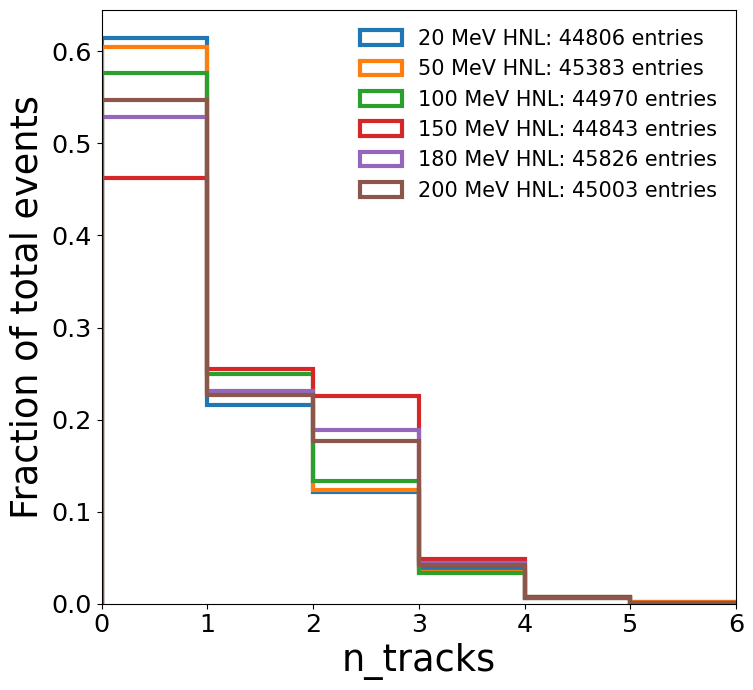

In [9]:
# Plot_variable_signal(var, HNL_samples_dict=plot_dict, xlabel=[], xlims=[0.01,0.5], bins=40, 
#                      figsize=[10,10], dpi=100, MergeBins=False, density=True,legloc="best",logy = False, cutline = None, savefig=False)

Plot_variable_signal(var, HNL_samples_dict=plot_dict, xlabel=[], xlims=[0,6], bins=6, 
                     figsize=[8,8], dpi=100, MergeBins=False, density=True,legloc="upper right",logy = False,
                     cutline = None, savefig=True, filename = None)

# max_y, bin_edges = np.histogram(plot_dict[150], density=True, bins=40)
# maxium = max(max_y)
# max_x = max(bin_edges)
# min_x = min(bin_edges)
# print(maxium)
# print(max_x)
# print(min_x)
# print("Max minus min is " + str(max_x - min_x))
# plt.ylim(0, maxium*1.3)

## 2D histogram of reco showers and tracks

In [12]:
a = np.arange(5) - 0.5
print(a)
#previously [0,4]

[-0.5  0.5  1.5  2.5  3.5]


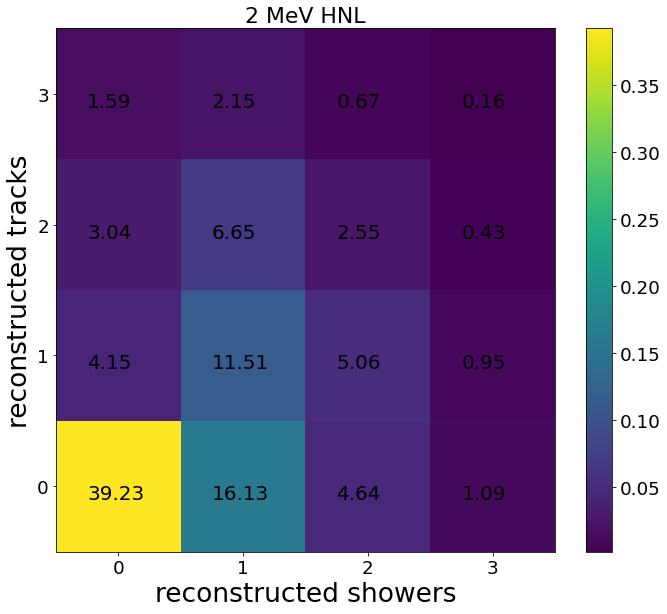

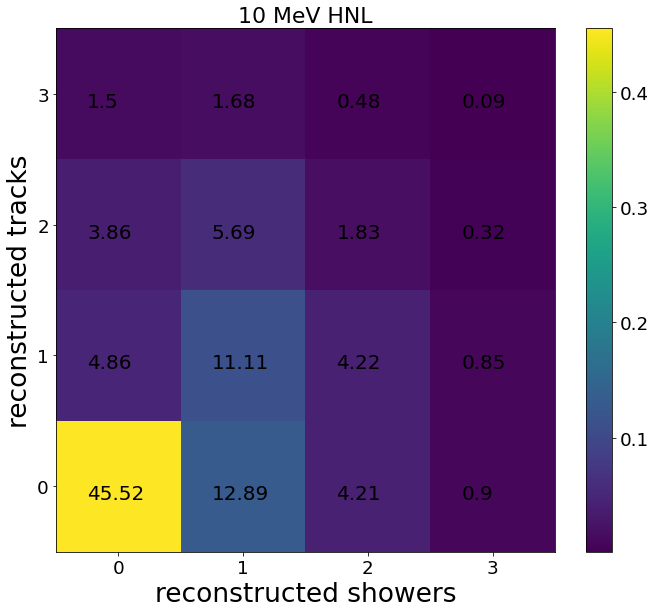

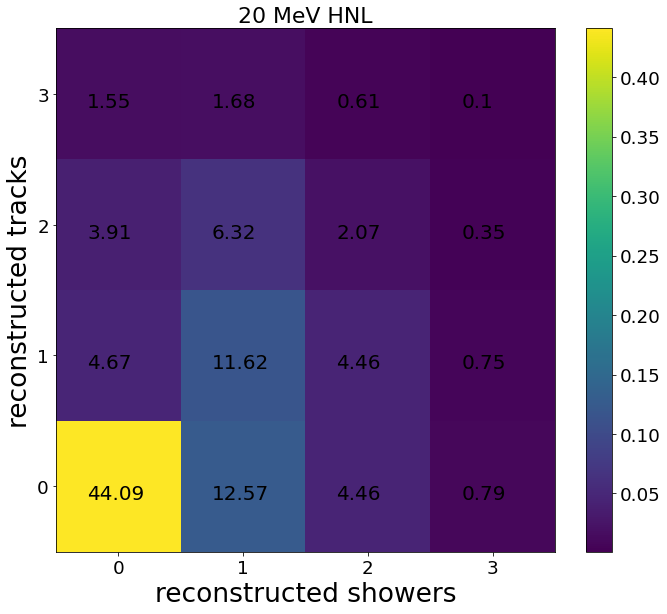

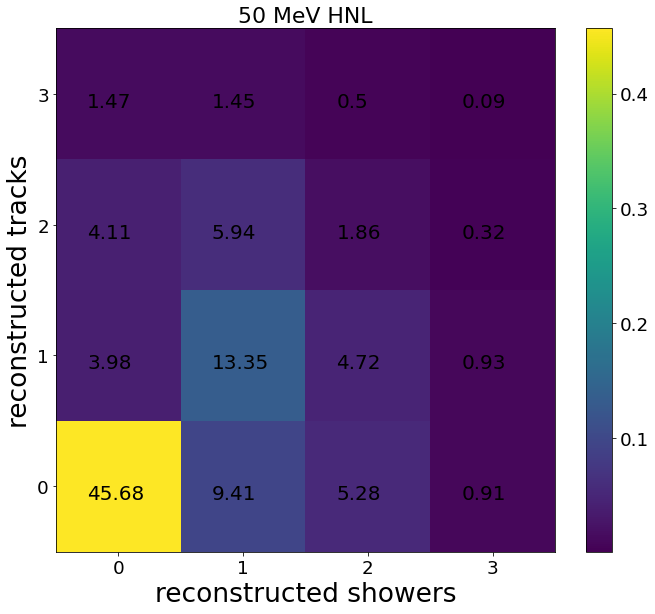

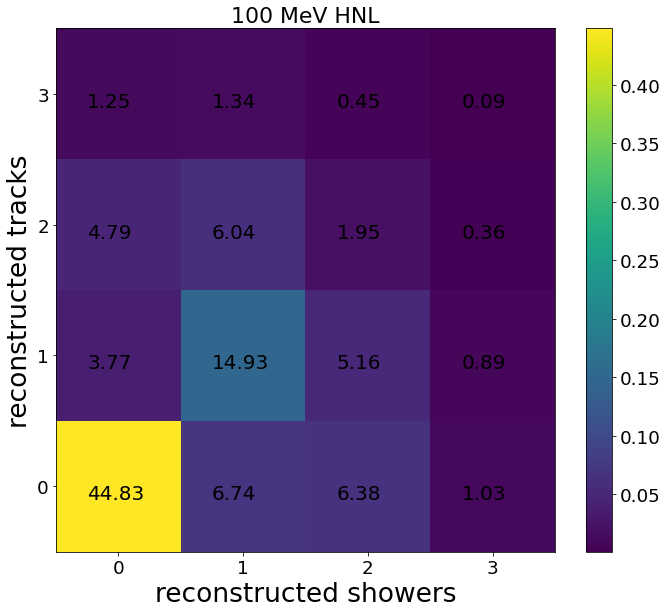

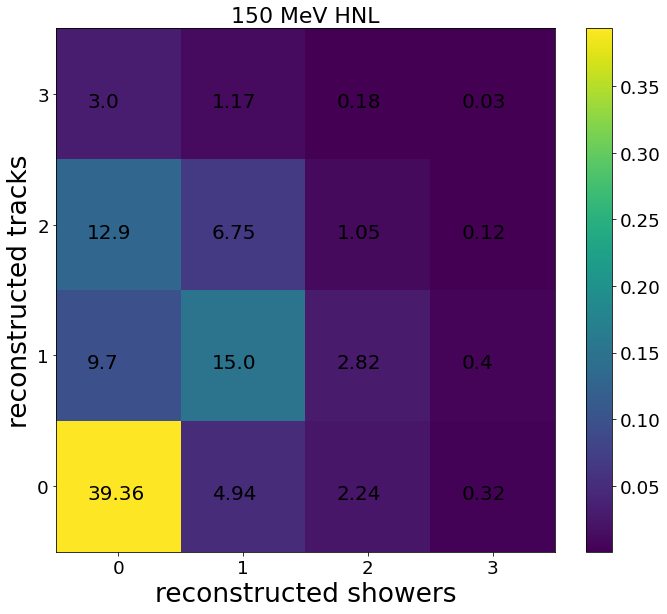

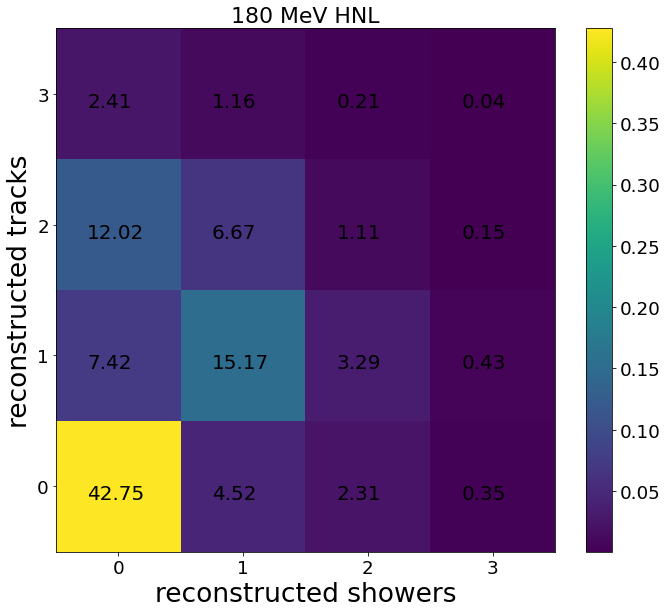

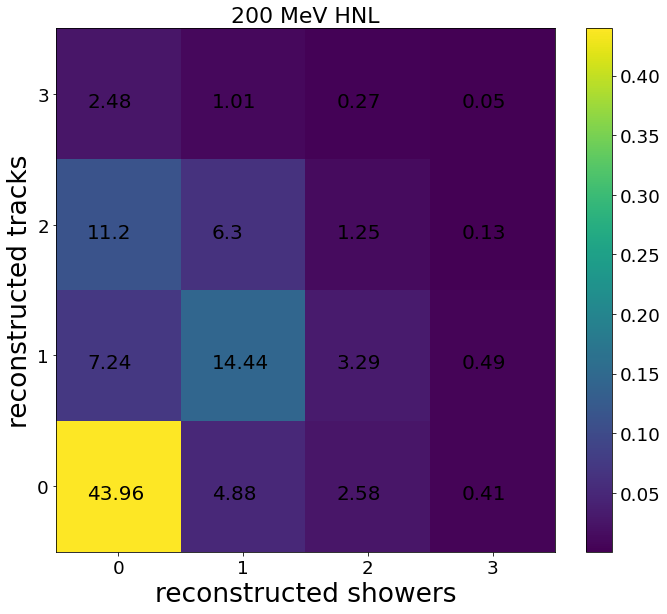

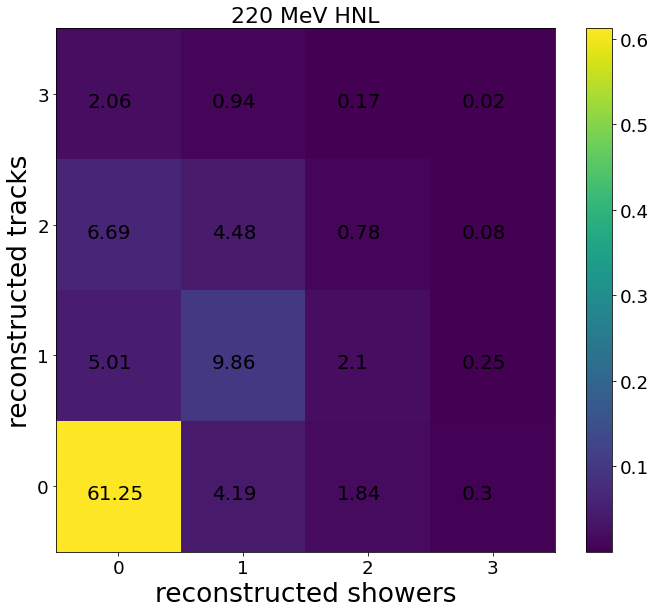

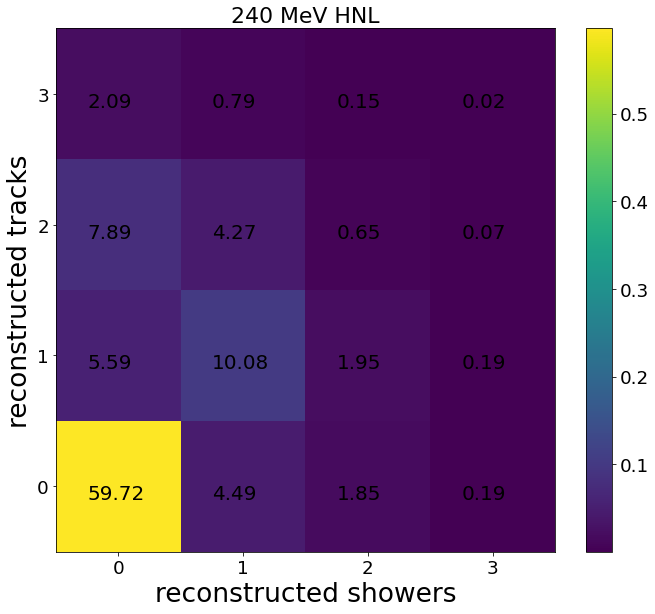

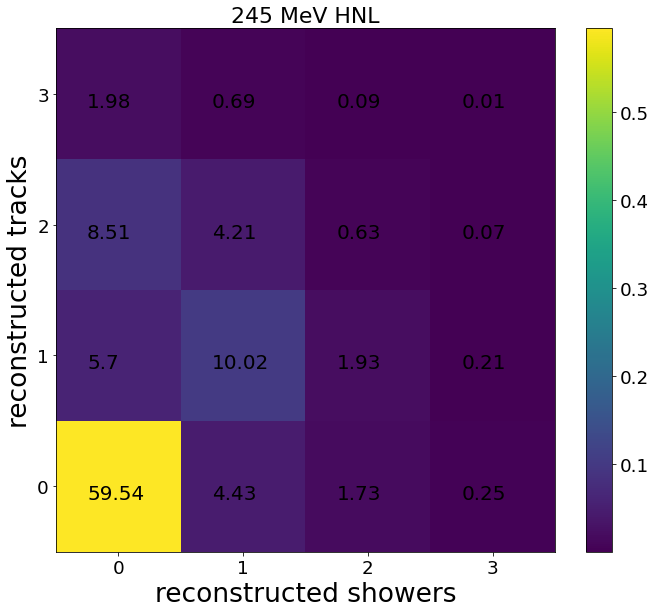

In [19]:
#HNL_mass = 20
savefig=True

for HNL_mass in HNL_masses:

    n_showers = plot_dict_2[HNL_mass]
    n_tracks = plot_dict[HNL_mass]

    width = 10
    aspect = 0.9
    height = width*aspect
    plt.figure(figsize=(width,height))
    
    BINS = np.arange(5)-0.5
    lims = [-1, 5]
    ticks = [0,1, 2, 3]
    old_bins = 4
    old_lims = [0,4]

    plt.hist2d(n_showers, n_tracks, bins = BINS, range=[lims,lims], density=True)

    counts, xedges, yedges, Image = plt.hist2d(n_showers, n_tracks, bins = BINS, range=[lims,lims], density=True)

    dx = xedges[2]-xedges[1]
    dy = yedges[2]-yedges[1]
    for i in range(xedges.size-1):
        for j in range(yedges.size-1):
            xb = xedges[i] + 0.25*dx
            yb = yedges[j] + 0.4*dy
            plt.text(xb, yb, str(np.round(100.*counts[i,j],2)), fontsize=20)

    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.title(str(HNL_mass) + " MeV HNL")
    plt.xlabel("reconstructed showers")
    plt.ylabel("reconstructed tracks")
    plt.colorbar()
    plt.tight_layout()
    if savefig==True:
        Name = f"Reconstructed_objects_{HNL_mass}MeV_{Run}"
        plt.savefig("plots/Truth_studies/Signal_plots/" + Name + ".png")

## Multiplicity study

In [5]:
def Make_fraction_recod(HNL_samples_dict=signal_samples_dict, variable='n_pfps'): #This should be fed with a dict of unflattened dataframes
    frac_pfps_dict = {}
    for HNL_mass in HNL_samples_dict:
        Placeholder_list = []
        Num_events = len(HNL_samples_dict[HNL_mass][variable])
        for i in range(max(HNL_samples_dict[HNL_mass][variable])):
            selection = HNL_samples_dict[HNL_mass].loc[(HNL_samples_dict[HNL_mass][variable] == i)]
            Num_multiplicity = len(selection)
            Placeholder_list.append(Num_multiplicity/Num_events)
        frac_pfps_dict[HNL_mass] = Placeholder_list
    return frac_pfps_dict

In [6]:
frac_pfps_dict = Make_fraction_recod(HNL_samples_dict=sample_dict, variable='n_pfps')

print(frac_pfps_dict)

{150: [0.403159181785136, 0.11430554178645781, 0.21797032484055384, 0.1567694392121873, 0.07465054029939526, 0.024883513433131752, 0.006344800237930009, 0.0014870625557648458]}


In [55]:
HNL_mass = 150
selection = sample_dict[HNL_mass].loc[(sample_dict[HNL_mass]['n_pfps'] == 2)]

print(len(selection))

10885


# Plotting variables before preselection

In [4]:
#Want to have arrows drawn on for where the preselection cut goes
HNL_mass = 200 #only plotting one at a time
variable = "crtveto"
samples = {"overlay":overlay_from_pkl,
           "dirtoverlay":dirt_from_pkl,
           "beamoff":EXT_from_pkl,
           "signal":signal_samples_dict[HNL_mass]}
samples.update(signal_samples_dict)
if Run == "run1":
    sample_norms = {"overlay":Constants.SF_overlay_run1,
           "dirtoverlay":Constants.SF_dirt_run1,
           "beamoff":Constants.SF_EXT_run1,
           "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
elif Run == "run3":
    sample_norms = {"overlay":Constants.SF_overlay_run3,
           "dirtoverlay":Constants.SF_dirt_run3,
           "beamoff":Constants.SF_EXT_run3,
           "signal":Constants.run3_POT_scaling_dict[HNL_mass]}
    
PT.HNL_scaling_calculator(samples,sample_norms)


The ratio of overlay to HNL events is 54005

The ratio of all bkgs to HNL events is 375468



In [5]:
for sample in samples:
    print(sample)

overlay
dirtoverlay
beamoff
signal
20
50
100
150
180
200


In [ ]:
PT.Plot_preselection_variable(variable, samples, sample_norms, xlabel=[],xlims=[0,2],bins=2, HNL_mass=HNL_mass,HNLplotscale=30000,cutline=1.0)
# plt.axvline(x=16.5, lw=3, color='green', linestyle = 'dashed')

#plt.savefig("plots/Preselection_variables/" + Run + "_" + str(HNL_mass) + "_MeV_" + str(variable)+".png")

## Plot only signal samples before preselection

In [4]:
#Need a new plotting function for this
print(overlay_from_pkl.keys())
print()
print(EXT_from_pkl.keys())

Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps', 'crtveto',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'weight'],
      dtype='object')

Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps', 'crtveto'],
      dtype='object')


# Pre-selection cuts

In [6]:
def Preselection_weighted_efficiency(samples, cut_dict, Efficiency_dict, Preselected): #Need to account for weigthing in overlay and dirt samples
    for sample in samples:
        if sample == "overlay" or sample == "dirtoverlay":
            weight = samples[sample]["weight"]
            NumEvs = sum(weight)
        else:
            NumEvs = len(samples[sample])
        
        effic_list = [1.0]
        for cut in cut_dict.keys():
            samples[sample]=samples[sample].query(cut_dict[cut])
            if sample == "overlay" or sample == "dirtoverlay":
                weight = samples[sample]["weight"]
                Num_selected = sum(weight)
            else:
                Num_selected = len(samples[sample])
            effic_list.append(Num_selected/NumEvs)
        Efficiency_dict[sample]=effic_list
        #samples.update()
        Selected = samples[sample].copy()
        placeholder_dict = {sample:Selected}
        Preselected.update(placeholder_dict) 
    

In [7]:
#Make cuts on signal
if Run == "run1": 
    if FLATTEN == True:
        Preselection_dict = Constants.Preselection_dict #Have also saved this in Constants.py, it is also here in case I want to add to or edit the cuts
    else:
        Preselection_dict = Constants.Preselection_dict_for_plot
elif Run == "run3":
    if FLATTEN == True:
        Preselection_dict = Constants.Preselection_dict
    else:
        Preselection_dict = Constants.Preselection_dict_for_plot
    Preselection_dict.update(Constants.Preselection_dict_crtveto) #Adding crtveto cut
    
print("Preselection is:" + "\n")
print(Preselection_dict)
print()

#"Containment":""
#"n_track":"n_track < 5"
#"shr_energy_tot":"shr_energy_tot < 1.0"
#"trk_len":"trk_len < 50.0"

#print(Signal_run1.numentries)
print("Numbers of rows in dataframes BEFORE Preselection:")
print("Overlay file has " + str(len(overlay_from_pkl)))
print("Dirt file has " + str(len(dirt_from_pkl)))
print("EXT file has " + str(len(EXT_from_pkl)))
#print(len(signal_from_pkl))



Preselection is:

{'nslice': 'nslice==1', 'flash_time': 'flash_time > 6.55 and flash_time < 16.5', 'nu_flashmatch_score': 'nu_flashmatch_score < 15', 'NeutrinoEnergy2': 'NeutrinoEnergy2 < 500', 'contained_fraction': 'contained_fraction > 0.9', 'trk_score': 'trk_score < 0.97', 'n_pfps': 'n_pfps < 6', 'crtveto': 'crtveto==0'}

Numbers of rows in dataframes BEFORE Preselection:
Overlay file has 748702
Dirt file has 389264
EXT file has 3211097


In [8]:
#Make cuts on bkg
# Preselection_efficiency_overlay = [1.0]
# Preselection_efficiency_dirt = [1.0]
# Preselection_efficiency_EXT = [1.0]

# Preselection_signal_max = []
# Preselection_signal_min = []

# Preselection_efficiency_signal_dict = {}
# for HNL_mass in HNL_masses:
#     Preselection_efficiency_signal_dict[HNL_mass] = [1.0]

# Selected_signal_from_pkl_dict = {}

    
# Selected_overlay_from_pkl = Preselection_with_list(overlay_from_pkl, Preselection_dict, Preselection_efficiency_overlay)
# Selected_dirt_from_pkl = Preselection_with_list(dirt_from_pkl, Preselection_dict, Preselection_efficiency_dirt)
# Selected_EXT_from_pkl = Preselection_with_list(EXT_from_pkl, Preselection_dict, Preselection_efficiency_EXT)

# for HNL_mass in HNL_masses:
#     Selected_signal_from_pkl_dict[HNL_mass] = Preselection_with_list(signal_samples_dict[HNL_mass], Preselection_dict, Preselection_efficiency_signal_dict[HNL_mass])

# print("AFTER Preselection:")
# print("Overlay .pkl is "+str(len(Selected_overlay_from_pkl))+" entries long.")
# print("Dirt .pkl is "+str(len(Selected_dirt_from_pkl))+" entries long.")
# print("EXT .pkl is "+str(len(Selected_EXT_from_pkl))+" entries long.")

# for HNL_mass in HNL_masses:
#     print(f"{HNL_mass}MeV Signal .pkl is "+str(len(Selected_signal_from_pkl_dict[HNL_mass]))+" entries long.")

Efficiency_dict = {}
Preselected_dict = {}
    
Preselection_weighted_efficiency(samples, Preselection_dict, Efficiency_dict, Preselected_dict)

print(Efficiency_dict)

{'overlay': [1.0, 0.4318984838245997, 0.4049839593228192, 0.27120382631468815, 0.17122708269547224, 0.05127564963921976, 0.036655494987959884, 0.036328605084700136, 0.03216327444734844], 'dirtoverlay': [1.0, 0.266215503056719, 0.25031447386200084, 0.13878330764194058, 0.09990176587297885, 0.014224486260637128, 0.01228477412639235, 0.012259094177210234, 0.007886967192912738], 'beamoff': [1.0, 0.11676944047470382, 0.10662057234645979, 0.07445928914635715, 0.06095300141976402, 0.010010909044479191, 0.007821003227246015, 0.007795466782847108, 0.003609669841801727], 'signal': [1.0, 0.5316090038441882, 0.5146323578428105, 0.4711019265382308, 0.4688131902317623, 0.352976468235451, 0.34511032597826813, 0.34391040597293515, 0.3364442370508633], 20: [1.0, 0.5645226085792081, 0.5477837789581752, 0.5034816765611748, 0.5011382404142303, 0.3957282506807124, 0.3897022720171406, 0.3863768245324287, 0.37809668347989106], 50: [1.0, 0.5478042438798669, 0.531168058524117, 0.48588678580085054, 0.4830663464

In [10]:
#Working out the maximum and minimum efficiencies for signal "band"
Preselection_signal_max = []
Preselection_signal_min = []

max_presel_effic = 0.0
min_presel_effic = 1.0
# for i in range(len(Preselection_dict)+1):
#     for HNL_mass in HNL_masses:
#         if Preselection_efficiency_signal_dict[HNL_mass][i] > max_presel_effic:
#             max_presel_effic = Preselection_efficiency_signal_dict[HNL_mass][i]
#         if Preselection_efficiency_signal_dict[HNL_mass][i] < min_presel_effic:
#             min_presel_effic = Preselection_efficiency_signal_dict[HNL_mass][i]
#     Preselection_signal_max.append(max_presel_effic)
#     Preselection_signal_min.append(min_presel_effic)
#     max_presel_effic = 0.0
    
for i in range(len(Preselection_dict)+1):
    for HNL_mass in HNL_masses:
        if Efficiency_dict[HNL_mass][i] > max_presel_effic:
            max_presel_effic = Efficiency_dict[HNL_mass][i]
        if Efficiency_dict[HNL_mass][i] < min_presel_effic:
            min_presel_effic = Efficiency_dict[HNL_mass][i]
    Preselection_signal_max.append(max_presel_effic)
    Preselection_signal_min.append(min_presel_effic)
    max_presel_effic = 0.0

In [11]:
print(Preselection_signal_max)
print(Preselection_signal_min)

[1.0, 0.6038623642486006, 0.5858885444773989, 0.5435407978948776, 0.5409093950003345, 0.4034520437972482, 0.39250273175300493, 0.3915661307227438, 0.38300292130321345]
[1.0, 0.5316090038441882, 0.5146323578428105, 0.4711019265382308, 0.4688131902317623, 0.352976468235451, 0.34511032597826813, 0.34391040597293515, 0.3364442370508633]


# Save pkls

In [15]:
print_vals = input("Do you want to save the pickle files? y/n ")
if print_vals == "y":
    loc_pkls = f"pkl_files/{Run}/current_files/"

    print(f"Saving {Run} Preselected overlay .pkl")
    Selected_overlay_from_pkl.to_pickle(loc_pkls+f"Preselected_overlay_{Run}_my_vars_flattened.pkl")

    print(f"Saving {Run} Preselected dirt .pkl")
    Selected_dirt_from_pkl.to_pickle(loc_pkls+f"Preselected_dirt_{Run}_my_vars_flattened.pkl")

    print(f"Saving {Run} Preselected EXT .pkl")
    Selected_EXT_from_pkl.to_pickle(loc_pkls+f"Preselected_EXT_{Run}_my_vars_flattened.pkl")
    for HNL_mass in HNL_masses:
        print(f"Saving {Run} Preselected {HNL_mass}MeV signal .pkl")
        Selected_signal_from_pkl_dict[HNL_mass].to_pickle(loc_pkls+f"Preselected_signal_{HNL_mass}MeV_{Run}_my_vars_flattened.pkl")
else:
    print("Not saving pickle files, move onto next cell")

Saving run3 Preselected overlay .pkl
Saving run3 Preselected dirt .pkl
Saving run3 Preselected EXT .pkl
Saving run3 Preselected 20MeV signal .pkl
Saving run3 Preselected 50MeV signal .pkl
Saving run3 Preselected 100MeV signal .pkl
Saving run3 Preselected 150MeV signal .pkl
Saving run3 Preselected 180MeV signal .pkl
Saving run3 Preselected 200MeV signal .pkl


# Plotting Efficiencies

Do you want to save the figure? y/n  y


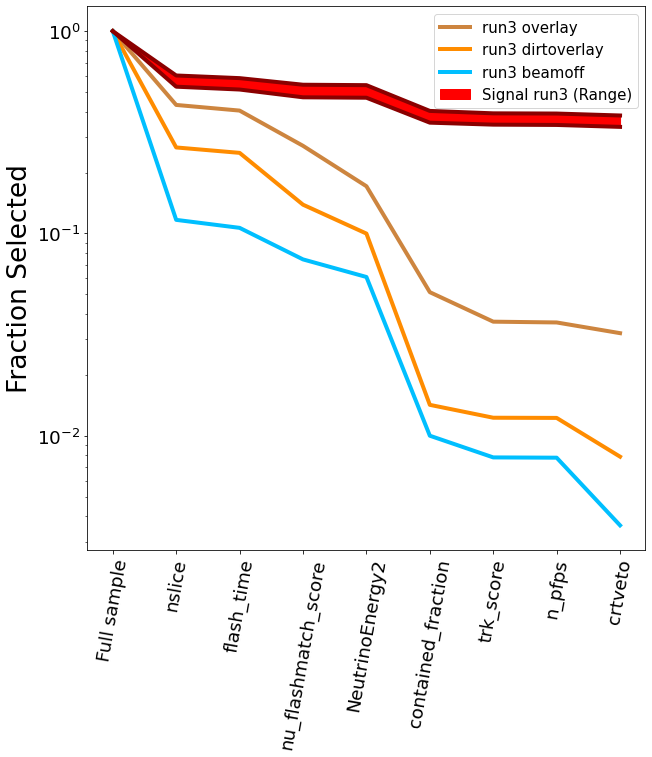

In [19]:
#Signal-only efficiencies
plt.figure(figsize=[10,10])
#print(Preselection_efficiency_signal_dict)
#print(len(Preselection_efficiency_signal_dict[HNL_mass]))
# for HNL_mass in HNL_masses:
#     plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)), Preselection_efficiency_signal_dict[HNL_mass], label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
#plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_signal,label="100 MeV HNL",lw=4,markersize=15)


# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_overlay,label=f"MC {Run} overlay",color='peru',lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_dirt,label=f"MC {Run} dirt",color="darkorange",lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_EXT,label=f"{Run} EXT",color='deepskyblue',lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_max,color="darkred",lw=4,marker="")
# plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_min,color="darkred",lw=4,marker="")
# plt.fill_between(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_min,Preselection_signal_max,label=f"Signal {Run} (Range)",color="red")
# plt.ylabel("Fraction Selected")
# plt.xticks(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
# #plt.yscale("log")
# plt.legend()

plotting_effic_dict = {'overlay':Efficiency_dict['overlay'], 'dirtoverlay':Efficiency_dict['dirtoverlay'],
                      'beamoff':Efficiency_dict['beamoff']}
plotting_effic_colours = {'overlay':'peru', 'dirtoverlay':'darkorange',
                      'beamoff':'deepskyblue'}
#, 'signal_max':Preselection_signal_max, 'signal_min':Preselection_signal_min}

log = True

if log == True:
    logscale="log"
elif log == False:
    logscale="linear"

for effic in plotting_effic_dict:
    #Efficiency_dict[effic]
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[effic],label=f"{Run} {effic}",color=plotting_effic_colours[effic],lw=4,markersize=15)

plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_max,color="darkred",lw=4,marker="")
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_min,color="darkred",lw=4,marker="")
plt.fill_between(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_min,Preselection_signal_max,label=f"Signal {Run} (Range)",color="red")
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict['overlay'])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
plt.yscale(logscale)
plt.legend()

save_fig = input("Do you want to save the figure? y/n ")

if save_fig == 'y':
    plt.savefig("plots/Preselection_efficiencies/" + Run + "_" + Flat_state + "_" + logscale + ".png")

[1.0, 0.5580340693291006, 0.542388254301182, 0.49757659930274084, 0.4948839318613418, 0.37113460502820217, 0.36614608429466283]


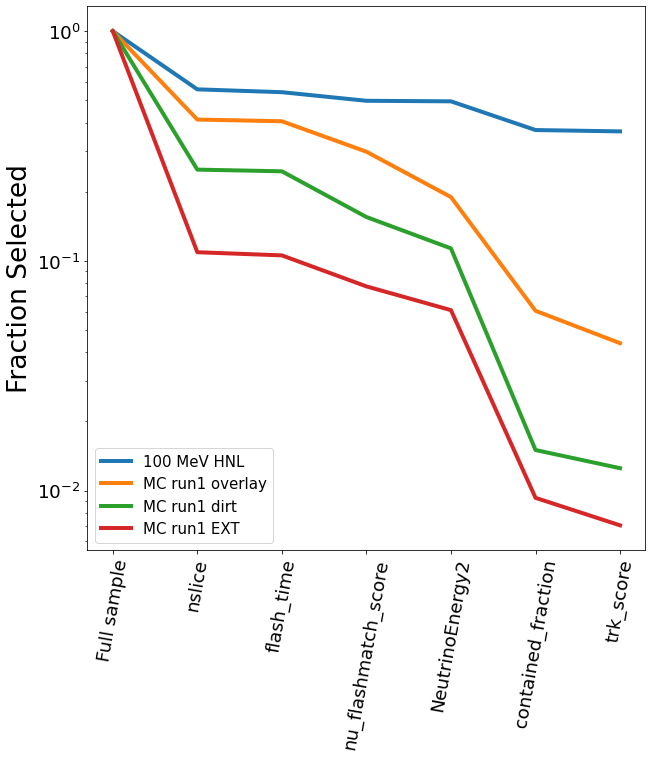

In [15]:
#Plotting efficiency
plt.figure(figsize=[10,10])
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_signal,label="100 MeV HNL",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_overlay,label="MC run1 overlay",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_dirt,label="MC run1 dirt",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_EXT,label="MC run1 EXT",lw=4,markersize=15)
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Preselection_efficiency_signal)+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
#plt.yscale("log")
plt.legend()

print(Preselection_efficiency_signal)


# Testing code

In [ ]:
#Testing what the variables look like
variable = "dvtx_x_boundary"
def test_variables(df):
    test_signal = df[variable]
    print(type(test_signal))
    print(len(test_signal))
test_variables(df_overlay_run1)
test_variables(df_dirt_run1)
test_variables(df_EXT_run1)
test_variables(df_signal_run1)

In [ ]:
#Single variables
plt.rcParams.update({'font.size': 22})

plot_variable = "n_showers"
range_list=[0,10]

Plot_one_variable(df_signal_run1, df_overlay_run1, plot_variable, 10, range_list, False) #With range
#Plot_one_variable(df_signal_run1, df_NuMI_MC_overlay_pdra_run1, plot_variable, None, loghist=False) #Without range

In [ ]:
#print(overlay_from_pkl['nslice'])
#print("Flat Overlay .pkl is "+str(len(FLAT_overlay_from_pkl))+" entries long.")

print("-----Unflattened-----")
unique_var = overlay_from_pkl["nslice"].unique()
print(unique_var)
unique_var = overlay_from_pkl["n_pfps"].unique()
print(unique_var)
print(overlay_from_pkl["n_pfps"])
print(type(overlay_from_pkl["n_pfps"][0]))

# for var in overlay_from_pkl.keys():
#     if type(overlay_from_pkl[var][1]) == "numpy.ndarray":
#         print(var)

# print("-----Flattened-----")
# unique_var = FLAT_overlay_from_pkl["nslice"].unique()
# print(unique_var)
# unique_var = FLAT_overlay_from_pkl["n_pfps"].unique()
# print(unique_var)
# print(FLAT_overlay_from_pkl["n_pfps"])
# print(type(FLAT_overlay_from_pkl["n_pfps"]))